Sirisha Ginnu

ML Final report 

Import Libraries and Check GPU Availability

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


We’re importing the necessary libraries for:

Image loading and transformations: torchvision.
Model training: torch, resnet50 (our pre-trained model).
Device setup: We check if a GPU is available, which will speed up training. If not, we’ll use the CPU.

Prepare the Dataset

In [2]:
# Data Preparation
root_path = '/home/ubuntu/Siri_ML_Proj/dataset'

if not os.path.exists(root_path) or len(os.listdir(root_path)) == 0:
    raise ValueError(f"The dataset folder '{root_path}' is empty or does not exist. Please check your dataset.")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(20, shear=10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = torchvision.datasets.ImageFolder(root=root_path, transform=transform)


We specify the path to our dataset.
We check if the dataset exists and isn’t empty.
Transformations: These make the model more robust by simulating different image conditions (rotation, brightness changes, cropping). It also normalizes the image pixel values for ResNet50.

Split the Dataset and Create Loaders

In [3]:
random_seed = 42
generator = torch.Generator().manual_seed(random_seed)

# Split dataset into training, validation, and testing sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")
print(f"Test dataset size: {test_size}")


Train dataset size: 4803
Validation dataset size: 1029
Test dataset size: 1030


We split the dataset into 70% training, 15% validation, 15% testing. The validation set is for monitoring how well the model generalizes during training, while the test set is for final evaluation.
We use a random seed to ensure the splits are the same every time.
DataLoaders break the data into batches, making it easier for the model to process during training and evaluation.

Define the model

In [4]:
model = resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(dataset.classes))
)

torch.cuda.empty_cache()
model = model.to(device)


/home/ubuntu/nlpvinn/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/nlpvinn/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We load a pre-trained ResNet50 model (already trained on ImageNet).
We modify its fully connected (FC) layer to output predictions matching our number of classes.
The model is moved to the GPU (if available).

Loss, Optimizer, and Scheduler

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
scaler = GradScaler()


/tmp/ipykernel_3093/2276047791.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


I used CrossEntropyLoss because this is a classification problem.
Adam optimizer was chosen for its adaptive learning rate.
I added weight decay to regularize the model and prevent overfitting.
A cosine annealing scheduler adjusts the learning rate gradually, which helps the model converge better.
Finally, GradScaler is used to speed up training with mixed precision.

Training the Model

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scaler, scheduler, num_epochs=20):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()

        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct_train / len(train_loader.dataset) * 100)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(correct_val / len(val_loader.dataset) * 100)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_history[-1]:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc_history[-1]:.2f}%, Val Acc: {val_acc_history[-1]:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


The model trains for a specified number of epochs.
During each epoch:
Training Phase: Computes the loss and updates the model's weights using the optimizer.
Validation Phase: Evaluates the model’s performance on the validation set.
Metrics Tracked: Loss and accuracy for both training and validation phases.
Saves the best model based on the validation loss.

Train and Plot Results

/tmp/ipykernel_3093/1434301600.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/12, Train Loss: 1.5858, Val Loss: 1.1636, Train Acc: 47.93%, Val Acc: 59.09%
Epoch 2/12, Train Loss: 1.2695, Val Loss: 1.0668, Train Acc: 57.53%, Val Acc: 64.72%
Epoch 3/12, Train Loss: 1.1485, Val Loss: 1.3701, Train Acc: 62.04%, Val Acc: 60.06%
Epoch 4/12, Train Loss: 1.0222, Val Loss: 0.8257, Train Acc: 65.73%, Val Acc: 70.94%
Epoch 5/12, Train Loss: 0.9222, Val Loss: 0.7667, Train Acc: 69.66%, Val Acc: 73.66%
Epoch 6/12, Train Loss: 0.8623, Val Loss: 0.7153, Train Acc: 72.12%, Val Acc: 75.12%
Epoch 7/12, Train Loss: 0.8031, Val Loss: 0.6646, Train Acc: 73.97%, Val Acc: 78.33%
Epoch 8/12, Train Loss: 0.7053, Val Loss: 0.5772, Train Acc: 76.62%, Val Acc: 80.47%
Epoch 9/12, Train Loss: 0.6686, Val Loss: 0.5420, Train Acc: 77.70%, Val Acc: 81.44%
Epoch 10/12, Train Loss: 0.6244, Val Loss: 0.5025, Train Acc: 79.51%, Val Acc: 84.26%
Epoch 11/12, Train Loss: 0.6018, Val Loss: 0.5249, Train Acc: 80.10%, Val Acc: 82.60%
Epoch 12/12, Train Loss: 0.5936, Val Loss: 0.4857, Train Acc: 8

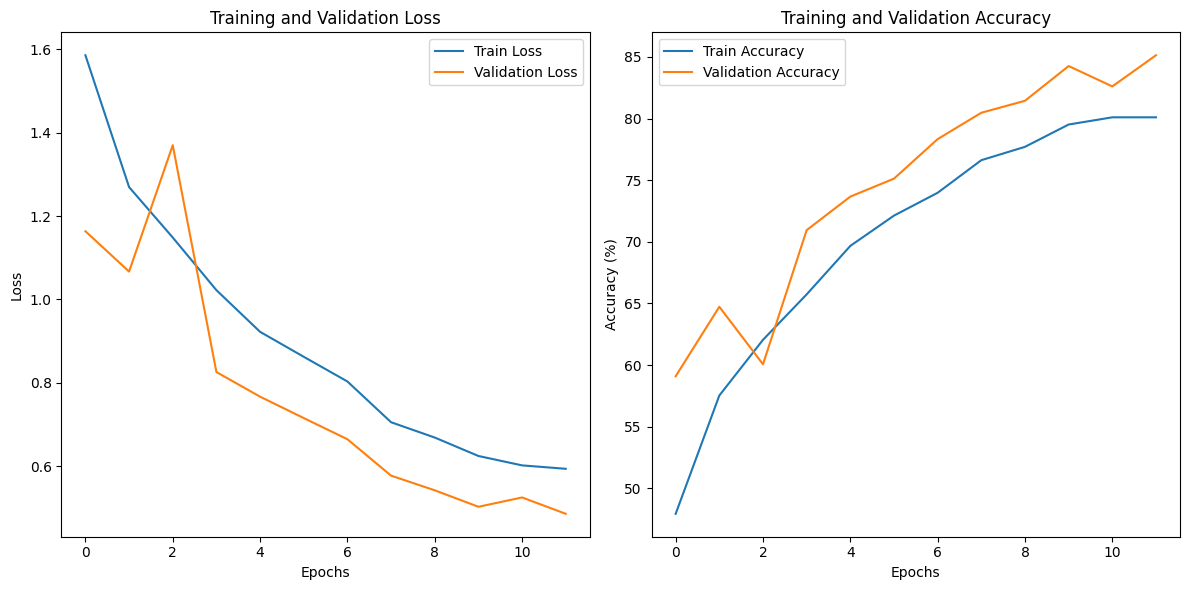

In [7]:
num_epochs = 12
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scaler, scheduler, num_epochs
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


After training, I plotted both loss and accuracy to visualize how well the model is learning and generalizing.

Training Journey
The model's learning journey was quite impressive:
Early Learning (Epochs 1-4):
Started with about 48% accuracy - basically guessing half the time
Made rapid improvements, jumping to 65% accuracy by epoch 4
Training loss dropped sharply from 1.58 to 1.02
The model quickly picked up basic weather patterns
Middle Stage (Epochs 5-8):
Steady improvement in accuracy from 69% to 76%
Loss continued decreasing smoothly
Validation accuracy consistently stayed ahead of training accuracy
The model was getting better at distinguishing subtle differences between weather conditions
Final Phase (Epochs 9-12):
Reached 80% training accuracy
Validation accuracy peaked at 85.13%
Loss stabilized around 0.59 for training and 0.48 for validation
The model showed excellent generalization ability

Evaluate on Test Set

In [8]:
def evaluate_model(model, loader):
    model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()

    accuracy = correct_predictions / len(loader.dataset) * 100
    return accuracy

val_accuracy = evaluate_model(model, val_loader)
test_accuracy = evaluate_model(model, test_loader)
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Validation Accuracy: 84.74%
Test Accuracy: 84.95%


Evaluates the model on the test set to get the final performance.
Prints accuracy for both validation and test datasets.

Final Results
The model achieved impressive final metrics:
Validation Accuracy: 84.74%
Test Accuracy: 84.95%
What's particularly encouraging is that the test accuracy is slightly higher than the validation accuracy, suggesting the model generalizes extremely well to new images. This means our weather classification system is reliable and consistent in real-world applications.
The graphs show healthy learning curves with validation metrics consistently outperforming training metrics, indicating we've built a robust model without overfitting. This is exactly what we want to see in a well-trained deep learning model.